In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [5]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
base_skin_dir = os.path.join('.', 'input')

In [7]:
base_skin_dir

'./input'

In [8]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [9]:
# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [10]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [11]:
# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [13]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4007,HAM_0001798,ISIC_0030141,nv,follow_up,50.0,male,back,./input/HAM10000_images_part_2/ISIC_0030141.jpg,Melanocytic nevi,4
8796,HAM_0004836,ISIC_0026674,nv,histo,35.0,male,lower extremity,./input/HAM10000_images_part_1/ISIC_0026674.jpg,Melanocytic nevi,4
7692,HAM_0006496,ISIC_0032579,nv,histo,55.0,female,lower extremity,./input/HAM10000_images_part_2/ISIC_0032579.jpg,Melanocytic nevi,4
872,HAM_0006770,ISIC_0028309,bkl,consensus,70.0,female,back,./input/HAM10000_images_part_1/ISIC_0028309.jpg,Benign keratosis-like lesions,2
1016,HAM_0006533,ISIC_0028497,bkl,consensus,80.0,male,face,./input/HAM10000_images_part_1/ISIC_0028497.jpg,Benign keratosis-like lesions,2
8997,HAM_0006821,ISIC_0030260,nv,histo,75.0,male,upper extremity,./input/HAM10000_images_part_2/ISIC_0030260.jpg,Melanocytic nevi,4
5179,HAM_0001282,ISIC_0028269,nv,follow_up,45.0,female,back,./input/HAM10000_images_part_1/ISIC_0028269.jpg,Melanocytic nevi,4
870,HAM_0000835,ISIC_0024409,bkl,confocal,55.0,female,face,./input/HAM10000_images_part_1/ISIC_0024409.jpg,Benign keratosis-like lesions,2
9025,HAM_0002888,ISIC_0029079,nv,histo,50.0,male,trunk,./input/HAM10000_images_part_1/ISIC_0029079.jpg,Melanocytic nevi,4
5009,HAM_0002085,ISIC_0031336,nv,follow_up,55.0,male,trunk,./input/HAM10000_images_part_2/ISIC_0031336.jpg,Melanocytic nevi,4


In [32]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [33]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [34]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [35]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [40]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [41]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


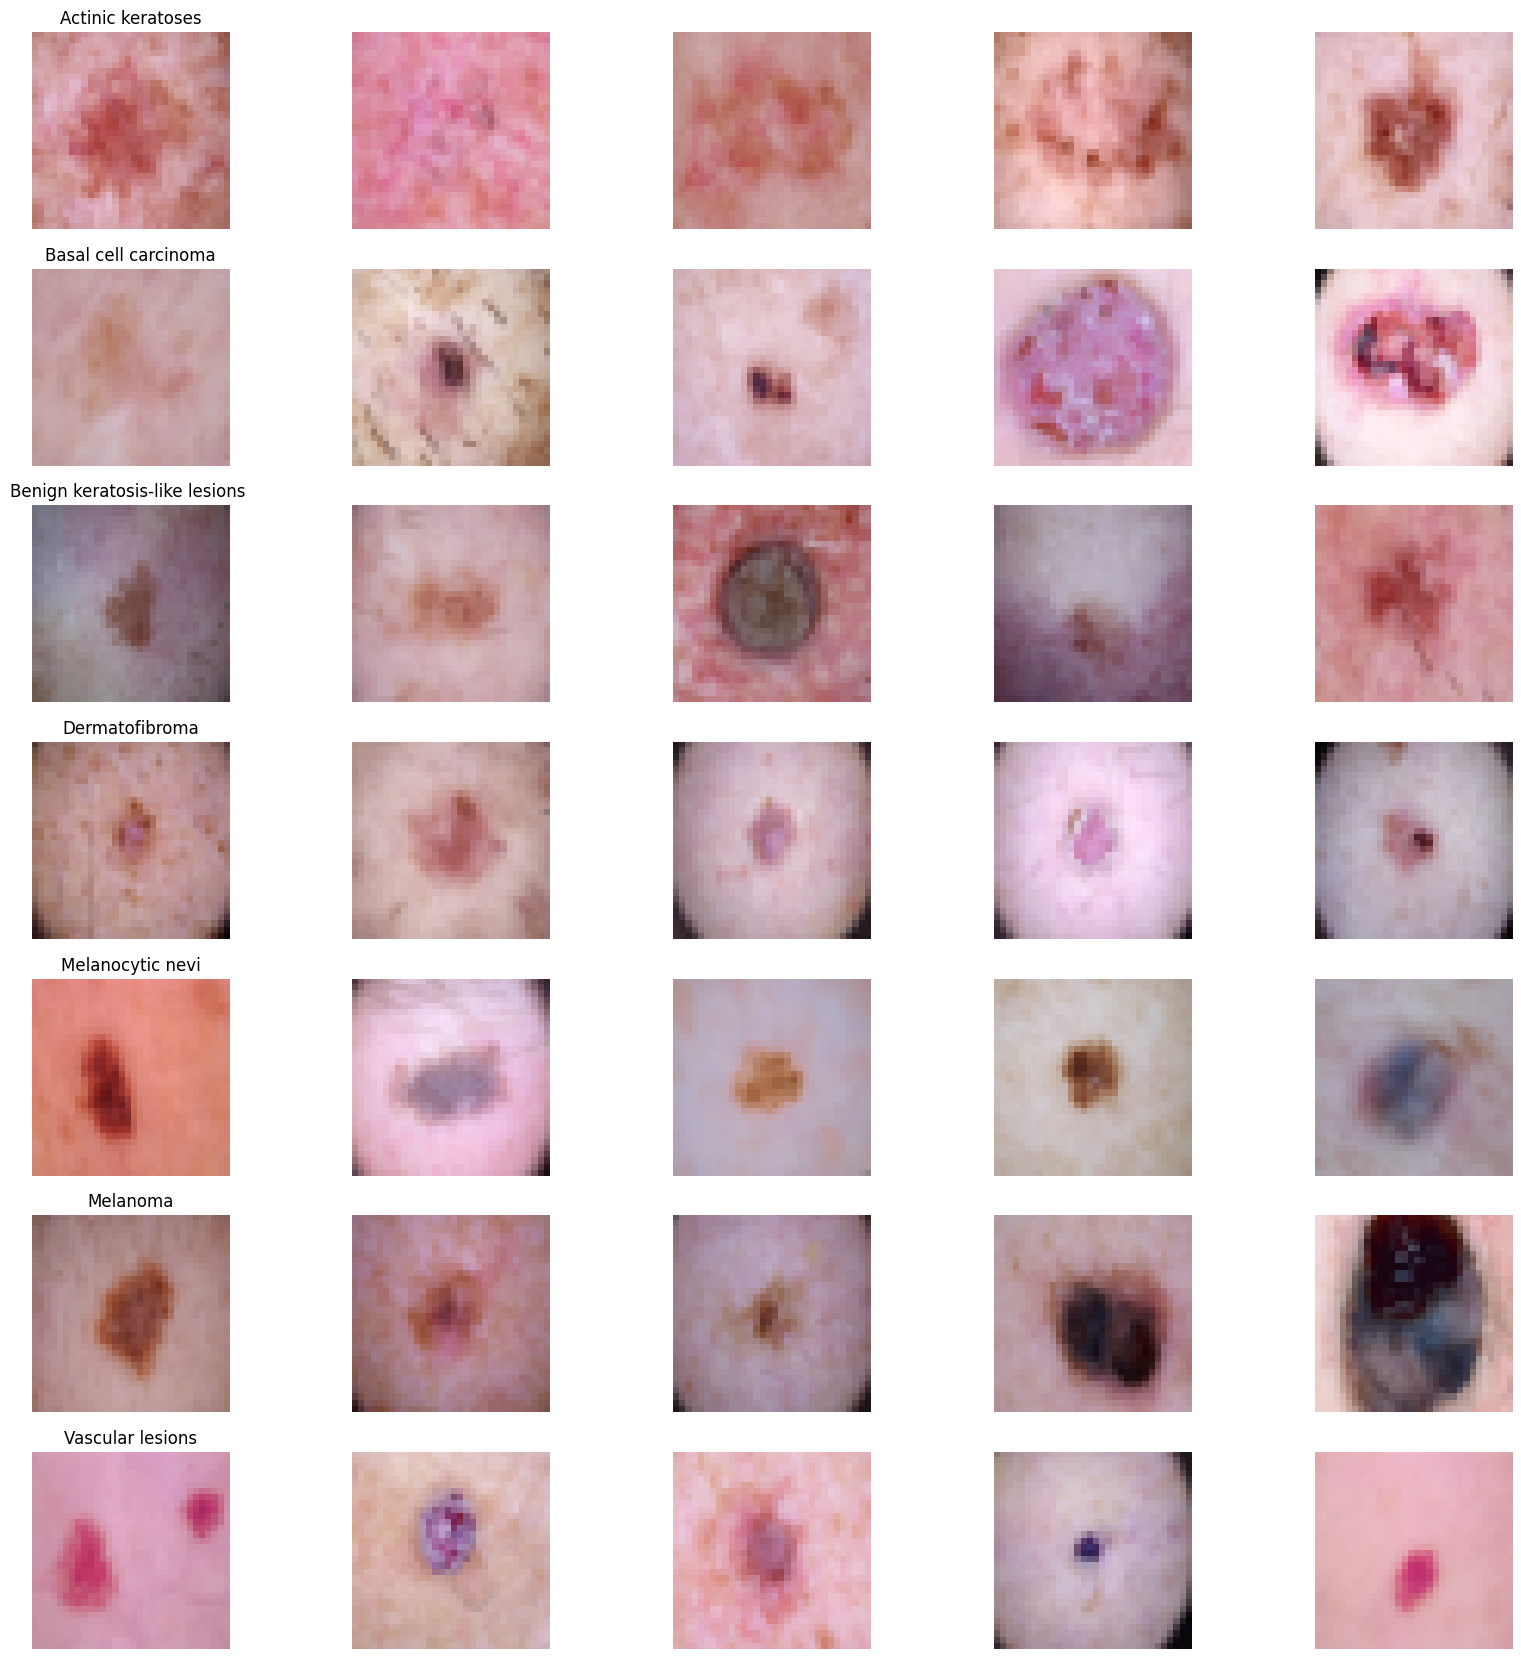

In [42]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [43]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(32, 32, 3)    10015
Name: count, dtype: int64

In [44]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [45]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [46]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [47]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [48]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [50]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))